# Classification Model

## Setting up the library

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
import zipfile
import tensorflow_hub as hub
import datetime
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from skimage import io, transform
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
# Extract the archive
#local_zip = '/content/drive/MyDrive/tesss/dataset capstone.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/content/drive/MyDrive/tesss/dataset capstone/')
#zip_ref.close()

In [ ]:
DIR = '/content/drive/MyDrive/tesss/dataset capstone/dataset capstone/dataset capstone'  # Change this to your specific directory

file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(DIR):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

In [ ]:
import pandas as pd

df = pd.DataFrame({"path":full_path,'/content/drive/MyDrive/tesss/dataset capstone/dataset capstone/dataset capstone':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Carton Packaging    739
Glass               370
Paper               523
Plastic Bottles     764
Tin Bottles         357
dtype: int64

In [ ]:
df.head()

,path,/content/drive/MyDrive/tesss/dataset capstone/dataset capstone/dataset capstone,tag
0,/content/drive/MyDrive/tesss/dataset capstone/...,cardboard230.jpg,Carton Packaging
1,/content/drive/MyDrive/tesss/dataset capstone/...,cardboard231.jpg,Carton Packaging
2,/content/drive/MyDrive/tesss/dataset capstone/...,cardboard232.jpg,Carton Packaging
3,/content/drive/MyDrive/tesss/dataset capstone/...,cardboard234.jpg,Carton Packaging
4,/content/drive/MyDrive/tesss/dataset capstone/...,cardboard233.jpg,Carton Packaging


### Train test split

In [ ]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

In [ ]:
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [ ]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)

In [ ]:
# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)

In [ ]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})


In [ ]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 2202
val size 275
test size 276


In [ ]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag             
test        Carton Packaging     67
            Glass                40
            Paper                43
            Plastic Bottles      83
            Tin Bottles          42
train       Carton Packaging    602
            Glass               291
            Paper               435
            Plastic Bottles     591
            Tin Bottles         283
validation  Carton Packaging     70
            Glass                39
            Paper                45
            Plastic Bottles      90
            Tin Bottles          32
dtype: int64 




<ipython-input-13-5fe41facacb4>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\


,path,tag,set
710,/content/drive/MyDrive/tesss/dataset capstone/...,Carton Packaging,train
2321,/content/drive/MyDrive/tesss/dataset capstone/...,Plastic Bottles,test
2717,/content/drive/MyDrive/tesss/dataset capstone/...,Tin Bottles,validation


In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
datasource_path = "/content/drive/MyDrive/tesss/dataset capstone/dataset capstone/dataset capstone"
dataset_path = "/content/drive/MyDrive/tesss/dataset"

In [ ]:
for index, row in tq(df_all.iterrows()):

    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])

    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Setting up global variables for training

In [ ]:
# Parameter input untuk network
dim = (150, 150)
channel = (3, )
input_shape = dim + channel
# Batch size
batch_size = 16
# Epoch
epoch = 10

## Preparing pipeline and augmentation datasets For dataset creation process

### Create the data flow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/tesss/dataset/train',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/tesss/dataset/validation',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/tesss/dataset/test',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

Found 2370 images belonging to 5 classes.
Found 377 images belonging to 5 classes.
Found 369 images belonging to 5 classes.


### Transform data generator into tf.data

In [ ]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


## Creating a Convolutional Neural Network Structure

In [ ]:
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)
num_classes = 5  # Replace 10 with the actual number of classes in your dataset
predictions = layers.Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

### Compile model

In [ ]:
# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
# Freeze the base layers (optional)
for layer in base_model.layers:
    layer.trainable = False


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model Visualisation

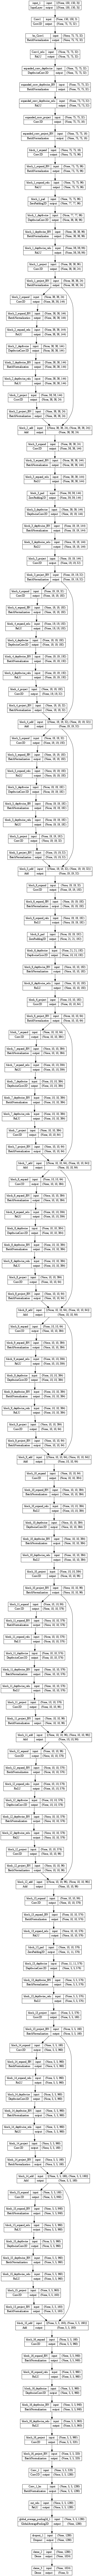

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='/content/drive/MyDrive/tesss/model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

### Proses Training Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    shuffle=True,
    verbose=1
)

Epoch 1/10
149/149 [==============================] - 638s 4s/step - loss: 0.7948 - accuracy: 0.7363 - val_loss: 0.4794 - val_accuracy: 0.8329
Epoch 2/10
149/149 [==============================] - 73s 483ms/step - loss: 0.4142 - accuracy: 0.8464 - val_loss: 0.3540 - val_accuracy: 0.8859
Epoch 3/10
149/149 [==============================] - 66s 444ms/step - loss: 0.3415 - accuracy: 0.8717 - val_loss: 0.2588 - val_accuracy: 0.8992
Epoch 4/10
149/149 [==============================] - 73s 487ms/step - loss: 0.3153 - accuracy: 0.8861 - val_loss: 0.3115 - val_accuracy: 0.8833
Epoch 5/10
149/149 [==============================] - 69s 465ms/step - loss: 0.2124 - accuracy: 0.9203 - val_loss: 0.2570 - val_accuracy: 0.9337
Epoch 6/10
149/149 [==============================] - 65s 433ms/step - loss: 0.2034 - accuracy: 0.9177 - val_loss: 0.3079 - val_accuracy: 0.9045
Epoch 7/10
149/149 [==============================] - 65s 434ms/step - loss: 0.2077 - accuracy: 0.9270 - val_loss: 0.2554 - val_accu

In [ ]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.9431 
Loss on training data: 0.1551 

Accuracy on test data: 0.9404 
Loss on test data: 0.1547 



## Fine tuning

In [ ]:
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 10/20
149/149 [==============================] - 62s 417ms/step - loss: 0.1230 - accuracy: 0.9591 - val_loss: 0.2293 - val_accuracy: 0.9257
Epoch 11/20
149/149 [==============================] - 67s 447ms/step - loss: 0.1038 - accuracy: 0.9612 - val_loss: 0.2650 - val_accuracy: 0.9204
Epoch 12/20
149/149 [==============================] - 65s 433ms/step - loss: 0.0978 - accuracy: 0.9620 - val_loss: 0.2671 - val_accuracy: 0.9125
Epoch 13/20
149/149 [==============================] - 60s 406ms/step - loss: 0.1085 - accuracy: 0.9553 - val_loss: 0.2137 - val_accuracy: 0.9416
Epoch 14/20
149/149 [==============================] - 65s 437ms/step - loss: 0.1068 - accuracy: 0.9608 - val_loss: 0.2414 - val_accuracy: 0.9337
Epoch 15/20
149/149 [==============================] - 68s 459ms/step - loss: 0.0958 - accuracy: 0.9667 - val_loss: 0.2950 - val_accuracy: 0.9072
Epoch 16/20
149/149 [==============================] - 62s 416ms/step - loss: 0.0781 - accuracy: 0.9709 - val_loss: 0.2381 -

In [ ]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.9187 
Loss on training data: 0.2308 

Accuracy on test data: 0.9268 
Loss on test data: 0.2049 



### Learning curves

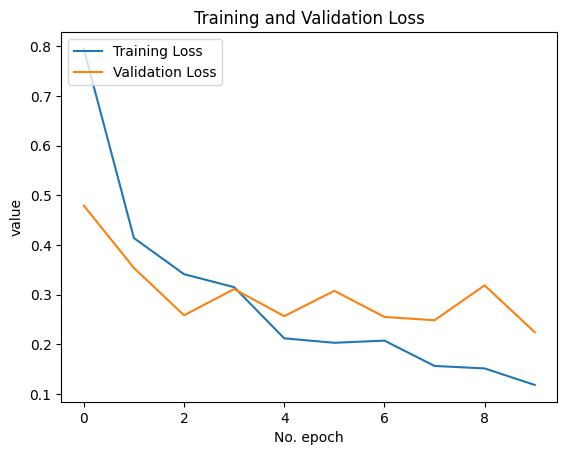

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Recommendation System Model and Classification

## Setting up the library & setting up global variables for training

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
# Parameters
input_size = (150,150) # Bisa kalian ganti
#define input shape
channel = (3,)
input_shape = input_size + channel
#define labels
labels = ['Carton Packaging', 'Glass', 'paper', 'Plastic Bottles', 'Tin Bottles']

**Define Recycling Recommendations**

In [ ]:
# Menambahkan rekomendasi daur ulang untuk setiap label
recycling_recommendations = [
    'Kertas daur ulang, Kotak penyimpanan, Bahan pembungkus, Pembatas atau pelindung dalam kotak pengiriman, lukisan, patung, mainan dan Hiasan dinding atau dekorasi rumah.',
    'Botol, Wadah kaca daur ulang, Vas bunga, Lampu hias, Patung kaca, Paving block, Mozaik dan Lukisan kaca.',
    'Memo, Kertas catatan, Kertas daur ulang, Kotak kardus, Kemasan kertas, Buku catatan, Kertas origami dan Karton.',
    'Serat tekstil, Wadah penyimpanan, Panel dinding, Kursi, Meja, Mainan anak-anak, Hiasan dinding dan Patung.',
    'Vas bunga, Toples, Patung kaca, Mangkuk, Gelas, Botol kaca daur ulang, Piring dan Cincin.'
]


**Creating the Mapping Dictionary**

In [ ]:
# Mengaitkan setiap label dengan rekomendasi daur ulang
label_recycling_dict = dict(zip(labels, recycling_recommendations))

**Save Recomendaation to HDF5**

In [ ]:
# Menyiapkan data untuk disimpan di dalam file HDF5
data_to_save = np.array(recycling_recommendations, dtype='S')

# Simpan ke dalam file HDF5
h5_filename = "rekomendasi_daur_ulang.h5"
with h5py.File(h5_filename, 'w') as hf:
    hf.create_dataset('recycling_recommendations', data=data_to_save)

# Jika Anda juga ingin menyimpan label
with h5py.File(h5_filename, 'a') as hf:
    hf.create_dataset('labels', data=np.array(labels, dtype='S'))

print(f"Data telah disimpan dalam file: {h5_filename}")

Data telah disimpan dalam file: rekomendasi_daur_ulang.h5


**generate recycling recommendations based on the predictions made by a mode**

In [ ]:
# Fungsi untuk mengeluarkan rekomendasi daur ulang berdasarkan prediksi model
def get_recycling_recommendation(prediction):
    label = labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    recommendation = label_recycling_dict[label]
    return label, confidence, recommendation

**preprocesses an input image before feeding it into a machine learning model**

In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

**Save Model Classification**

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/tesss/model"
PROJECT_NAME = "/content/drive/MyDrive/tesss/model/medium_project"
SAVE_MODEL_NAME = "/content/drive/MyDrive/tesss/model/medium_project/model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/tesss/model/medium_project/model.h5...


**Combine Classification and Recomendation to HDF5**


In [ ]:
# Path ke model pertama yang disimpan dalam format HDF5
h5_filename = "rekomendasi_daur_ulang.h5"

# Path ke model Keras yang disimpan sebelumnya
saved_keras_model_path = "/content/drive/MyDrive/tesss/model/medium_project/model.h5"

# Memuat model pertama yang disimpan dalam format HDF5
with h5py.File(h5_filename, 'r') as hf:
    recycling_recommendations_loaded = hf['recycling_recommendations'][:]
    labels_loaded = hf['labels'][:]

# Memuat model Keras yang disimpan sebelumnya
loaded_keras_model = load_model(saved_keras_model_path)

# Melakukan operasi gabungan atau penyatuan model di sini
# Misalnya, menggunakan 'loaded_keras_model' sebagai bagian dari model gabungan

# Simpan model gabungan ke lokasi yang ditentukan
combined_model_save_path = "combined_model.h5"
loaded_keras_model.save(combined_model_save_path)

print(f"Model gabungan telah disimpan di: {combined_model_save_path}")

Model gabungan telah disimpan di: combined_model.h5


**Load Model**

In [ ]:
from tensorflow.keras.models import load_model
MODEL_PATH = '/content/combined_model.h5'
model = load_model(MODEL_PATH,compile=False)

**Tes the Model**

In [ ]:
im = Image.open('/content/drive/MyDrive/tesss/TES/kaleng.jpg')
X = preprocess(im, input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 1s 1s/step
Tin Bottles 0.9826401
Recycling Recommendation: Vas bunga, Toples, Patung kaca, Mangkuk, Gelas, Botol kaca daur ulang, Piring dan Cincin.


In [ ]:
# read image
im = Image.open('/content/drive/MyDrive/tesss/TES/botol.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 41ms/step
Plastic Bottles 0.9999957
Recycling Recommendation: Serat tekstil, Wadah penyimpanan, Panel dinding, Kursi, Meja, Mainan anak-anak, Hiasan dinding dan Patung.


In [ ]:
# read image
im = Image.open('/content/drive/MyDrive/tesss/TES/botol2.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 41ms/step
Plastic Bottles 0.9999994
Recycling Recommendation: Serat tekstil, Wadah penyimpanan, Panel dinding, Kursi, Meja, Mainan anak-anak, Hiasan dinding dan Patung.


In [ ]:
# read image
im = Image.open('/content/drive/MyDrive/tesss/TES/koran.jpeg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 38ms/step
paper 0.99569964
Recycling Recommendation: Memo, Kertas catatan, Kertas daur ulang, Kotak kardus, Kemasan kertas, Buku catatan, Kertas origami dan Karton.


In [ ]:
# read image
im = Image.open('/content/drive/MyDrive/tesss/TES/koran.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 37ms/step
paper 0.99999976
Recycling Recommendation: Memo, Kertas catatan, Kertas daur ulang, Kotak kardus, Kemasan kertas, Buku catatan, Kertas origami dan Karton.


In [ ]:
# read image
im = Image.open('/content/drive/MyDrive/tesss/TES/gelas.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 72ms/step
Glass 0.75629956
Recycling Recommendation: Botol, Wadah kaca daur ulang, Vas bunga, Lampu hias, Patung kaca, Paving block, Mozaik dan Lukisan kaca.


In [ ]:
# read image
im = Image.open('/content/kert.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )
label, confidence, recommendation = get_recycling_recommendation(y)
print(f'Recycling Recommendation: {recommendation}')

1/1 [==============================] - 0s 204ms/step
Plastic Bottles 0.8068046
Recycling Recommendation: Serat tekstil, Wadah penyimpanan, Panel dinding, Kursi, Meja, Mainan anak-anak, Hiasan dinding dan Patung.


**Converting the Keras model to TensorFlow Lite format and save**

In [ ]:
import tensorflow as tf

# Load the combined model
loaded_model = tf.keras.models.load_model("/content/combined_model.h5")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TFLite model to a file with .tflite extension
tflite_filename = "model_baru.tflite"  # Ubah nama file sesuai keinginan Anda dengan ekstensi .tflite
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

print(f"Model TFLite telah disimpan di: {tflite_filename}")


Model TFLite telah disimpan di: model_baru.tflite
